## Wearable activity classification
We build an activity classifier using data from a wrist wearable (PPG dataset). After feature engineering and data exploration analysis (EDA), we optimized the hyperparameters (LOOCV) and created machine learning modeling (random forest), finally evaluated the performance of model.

In [70]:
import collections
import glob
import os
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import scipy.stats
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

In [2]:
### Names of Files
fs = 256
data_dir = '../../data/'
filenames = [os.path.splitext(f)[0] for f in sorted(os.listdir(data_dir))]
filenames

['s1_bike_0',
 's1_bike_1',
 's1_walk',
 's2_bike_0',
 's2_bike_1',
 's2_walk',
 's3_bike_0',
 's3_bike_1',
 's3_run',
 's3_walk',
 's4_run',
 's5_run',
 's6_run',
 's6_walk',
 's8_run',
 's8_walk',
 's9_walk']

In [3]:
### Class of activities
subjects_per_class = collections.defaultdict(set)
for f in filenames:
    subject = f.split('_')[0]
    activity = f.split('_')[1]
    subjects_per_class[activity].add(subject)
{k: len(v) for k, v in subjects_per_class.items()}

{'bike': 3, 'walk': 6, 'run': 5}

### Load data

In [4]:
data = []
for f in filenames:
    subject = f.split('_')[0]
    activity = f.split('_')[1]
    path = os.path.join(data_dir, f + '.csv')
    df = pd.read_csv(path)
    df = df.loc[: df.last_valid_index()]
    data.append((subject, activity, df))
df.head()

,accx,accy,accz
0,3.791152,-9.329793,1.622757
1,3.791152,-9.329285,1.646969
2,3.791366,-9.304383,1.695834
3,3.767274,-9.267029,1.732482
4,3.780279,-9.194481,1.770231


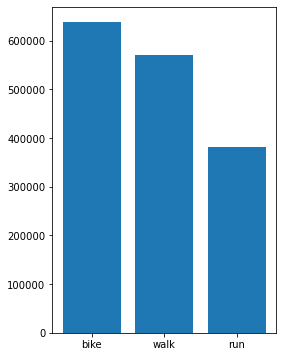

In [5]:
# Plot number of datapoints per class
samples_per_class = collections.defaultdict(int)
for subject, activity, df in data:
    samples_per_class[activity] += len(df)
    
activity, n_samples = list(zip(*samples_per_class.items()))
plt.figure(figsize=(4, 6))
plt.bar(range(3), n_samples)
plt.xticks(range(3), activity);

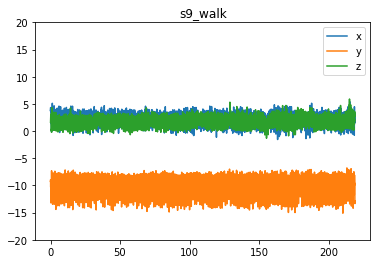

In [6]:
# Plot raw data
for subject, activity, df in sorted(data, key=lambda x: x[1]):
    ts = np.arange(len(df)) / fs
    plt.clf()
    plt.plot(ts, df.accx, label='x')
    plt.plot(ts, df.accy, label='y')
    plt.plot(ts, df.accz, label='z')
    plt.title('{}_{}'.format(subject, activity))
    plt.legend()
    plt.ylim((-20, 20)) 
    plt.draw()

### Feature Extraction 

In [7]:
def LowpassFilter(signal, fs):
    b, a = sp.signal.butter(3, 12, btype='lowpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

In [8]:
def Featurize(accx, accy, accz, fs):   
    accx = LowpassFilter(accx, fs)     # x-channel of the accelerometer.
    accy = LowpassFilter(accy, fs)     # y-channel of the accelerometer.
    accz = LowpassFilter(accz, fs)     # z-channel of the accelerometer.

    mn_x = np.mean(accx)               # mean of the x-channel
    std_x = np.std(accx)               # standard deviation of the x-channel
    p5_x = np.percentile(accx, 5)      # 5th percentile of the x-channel
    corr_xy = sp.stats.pearsonr(accx, accy)[0]   # pearson correlation coefficient between the x and y channels
    energy_x = np.sum(np.square(accx - np.mean(accx)))  # np.var(accx) * len(accx)
        
    fft_len = max(len(accx), 2046)     # Take an FFT of the signal. 
    freqs = np.fft.rfftfreq(fft_len, 1 / fs)  # Create an array of frequency bins
    fft_x = np.fft.rfft(accx - np.mean(accx), fft_len)  # Take an FFT of the centered signal
    low_freqs = (freqs >= 0.25) & (freqs <= 12)         # frequency with the most power between 0.25 and 12 Hz
    dominant_frequency_x = freqs[low_freqs][np.argmax(np.abs(fft_x)[low_freqs])]

    # The fraction of energy between 2 and 3 Hz in the x-channel
    spectral_energy_x = np.square(np.abs(fft_x))
    energy_23_x = (np.sum(spectral_energy_x[(freqs >= 2) & (freqs <= 3)])
                   / np.sum(spectral_energy_x))    
    return (mn_x, std_x,p5_x,corr_xy,energy_x,dominant_frequency_x,energy_23_x)

In [45]:
def GenerateFeatures(data, fs, window_length_s, window_shift_s):
  window_length = window_length_s * fs      #  window_length_s: (number) The length of the window in seconds
  window_shift = window_shift_s * fs        #  window_shift_s: (number) The amount to shift the window by
  labels, subjects, features = [], [], []
  for subject, activity, df in data:
    for i in range(0, len(df) - window_length, window_shift):
      window = df[i: i + window_length]
      accx = window.accx.values
      accy = window.accy.values
      accz = window.accz.values
      features.append(activity_classifier_utils.Featurize(accx, accy, accz, fs=fs))    # o
      labels.append(activity)
      subjects.append(subject)
  labels = np.array(labels)
  subjects = np.array(subjects)
  features = np.array(features)
  return labels, subjects, features

labels, subjects, features = GenerateFeatures(data,fs,window_length_s=10,window_shift_s=10)
print(features.shape, labels.shape, subjects.shape)

(611, 55) (611,) (611,)


### Hyperparameter Tuning (Leave-One-Out Cross Validation)

In [46]:
# leave-one-subject-out cross validation. 
n_estimators_opt = [2, 10, 20, 50, 100, 150, 300]
max_tree_depth_opt = range(2, 7)
class_names = np.array(['bike', 'run', 'walk'])
logo = LeaveOneGroupOut()               
accuracy_table = []

import itertools
for n_estimators, max_tree_depth in itertools.product(n_estimators_opt, max_tree_depth_opt):    
    cm = np.zeros((3, 3), dtype='int')                     # Iterate over each pair of hyperparameters                     
    clf = RandomForestClassifier(n_estimators=n_estimators,  
                                 max_depth=max_tree_depth,   
                                 random_state=42,
                                 class_weight='balanced')
    for train_ind, test_ind in logo.split(features, labels, subjects):  # leave-one-subject-out cross validation.        
        X_train, y_train = features[train_ind], labels[train_ind]
        X_test, y_test = features[test_ind], labels[test_ind]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        c = confusion_matrix(y_test, y_pred, labels=class_names)
        cm += c
    classification_accuracy = np.sum(np.diag(cm)) / np.sum(np.sum(cm))
    accuracy_table.append((n_estimators, max_tree_depth, classification_accuracy))
    
accuracy_table_df = pd.DataFrame(accuracy_table, columns=['n_estimators', 'max_tree_depth', 'accuracy'])
accuracy_table_df.head()

,n_estimators,max_tree_depth,accuracy
0,2,2,0.787234
1,2,3,0.605565
2,2,4,0.687398
3,2,5,0.656301
4,2,6,0.815057


In [47]:
accuracy_table_df.loc[accuracy_table_df.accuracy.idxmax()]

n_estimators      150.000000
max_tree_depth      2.000000
accuracy            0.893617
Name: 25, dtype: float64

In [48]:
def LOSOCVPerformance(features, labels, subjects, clf):
  class_names = ['bike', 'walk', 'run']
  logo = LeaveOneGroupOut()
  cm = np.zeros((3, 3), dtype='int')
  for train_ind, test_ind in logo.split(features, labels, subjects):
    X_train, y_train = features[train_ind], labels[train_ind]
    X_test, y_test = features[test_ind], labels[test_ind]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    c = confusion_matrix(y_test, y_pred, labels=class_names)
    cm += c
  return cm

In [49]:
# Plot 
def PlotConfusionMatrix(cm, classes,normalize=False,title=None,cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig = plt.figure(figsize=(8, 5))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    ax = fig.get_axes()[0]
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           xlim=(-.5, len(classes) - .5),
           ylim=(len(classes) - .5, -.5),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [50]:
# Feature Importance
clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42,class_weight='balanced')
LOSOCVPerformance(features, labels, subjects, clf)
clf.feature_importances_
# sorted(list(zip(clf.feature_importances_, FeatureNames())), reverse=True)[:10]

array([0.00134753, 0.01051275, 0.01120962, 0.00639338, 0.05877445,
       0.03409163, 0.03695069, 0.00785631, 0.08654943, 0.01867305,
       0.00581379, 0.06387512, 0.00350326, 0.00857635, 0.06280435,
       0.00081488, 0.00466611, 0.0191422 , 0.00229894, 0.01263926,
       0.00765743, 0.00217305, 0.00136973, 0.00168822, 0.01295911,
       0.04591638, 0.03239733, 0.00099882, 0.00141245, 0.00139248,
       0.00087951, 0.03300667, 0.01183622, 0.01578849, 0.00657018,
       0.00097436, 0.00289558, 0.00155387, 0.00252563, 0.00129723,
       0.00513178, 0.00171782, 0.00154356, 0.00417938, 0.09802952,
       0.02588011, 0.06256737, 0.08374541, 0.03013957, 0.00180204,
       0.01757478, 0.01495077, 0.00624965, 0.00201094, 0.00269148])

In [83]:
sorted_features = sorted(zip(clf.feature_importances_, np.arange(len(clf.feature_importances_))), reverse=True)
best_feature_indices = list(zip(*sorted_features))[1]
X = features[:, best_feature_indices[:10]]

### Build a Random Forest Classifier 

In [84]:
# Build and train the model
n_estimators = 100    # build a forest with 100 trees 
max_tree_depth = 4    # maximum depth of 4

clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_tree_depth, random_state=42)
clf.fit(features, labels)

RandomForestClassifier(max_depth=4, random_state=42)

In [85]:
class_names = np.array(['bike', 'run', 'walk'])
logo = LeaveOneGroupOut()
cm = np.zeros((3, 3), dtype='int')

for train_ind, test_ind in logo.split(features, labels, subjects):
    X_train, y_train = features[train_ind], labels[train_ind]
    X_test, y_test = features[test_ind], labels[test_ind]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    c = confusion_matrix(y_test, y_pred, labels=class_names)
    cm += c

Confusion matrix, without normalization
[[140   1 104]
 [  2 142   3]
 [ 13  18 188]]


<AxesSubplot:title={'center':'classifier performance'}, xlabel='Predicted label', ylabel='True label'>

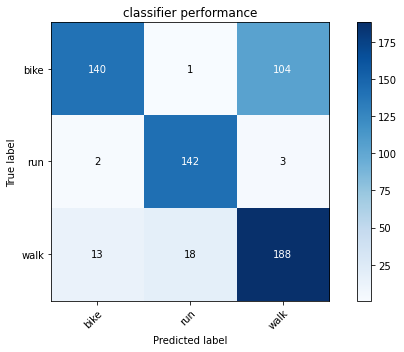

In [86]:
# Plot confusion matrices
class_names = ['bike', 'run', 'walk']
PlotConfusionMatrix(cm, class_names,title='classifier performance', normalize=False)

Normalized confusion matrix
[[0.57142857 0.00408163 0.4244898 ]
 [0.01360544 0.96598639 0.02040816]
 [0.05936073 0.08219178 0.85844749]]


<AxesSubplot:title={'center':'normalized classifier performance'}, xlabel='Predicted label', ylabel='True label'>

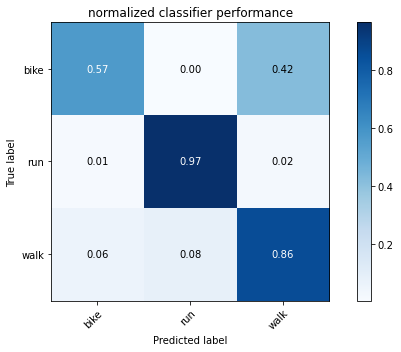

In [87]:
PlotConfusionMatrix(cm, class_names, title='normalized classifier performance',normalize=True)

In [88]:
# Classificatino accuracy
print(np.sum(np.diag(cm)) / np.sum(np.sum(cm)))

0.7692307692307693


In [89]:
## We seem to be really good at classifying run. We don't really mistake run for either bike or walk and don't misclassify the other classes as run often.